# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


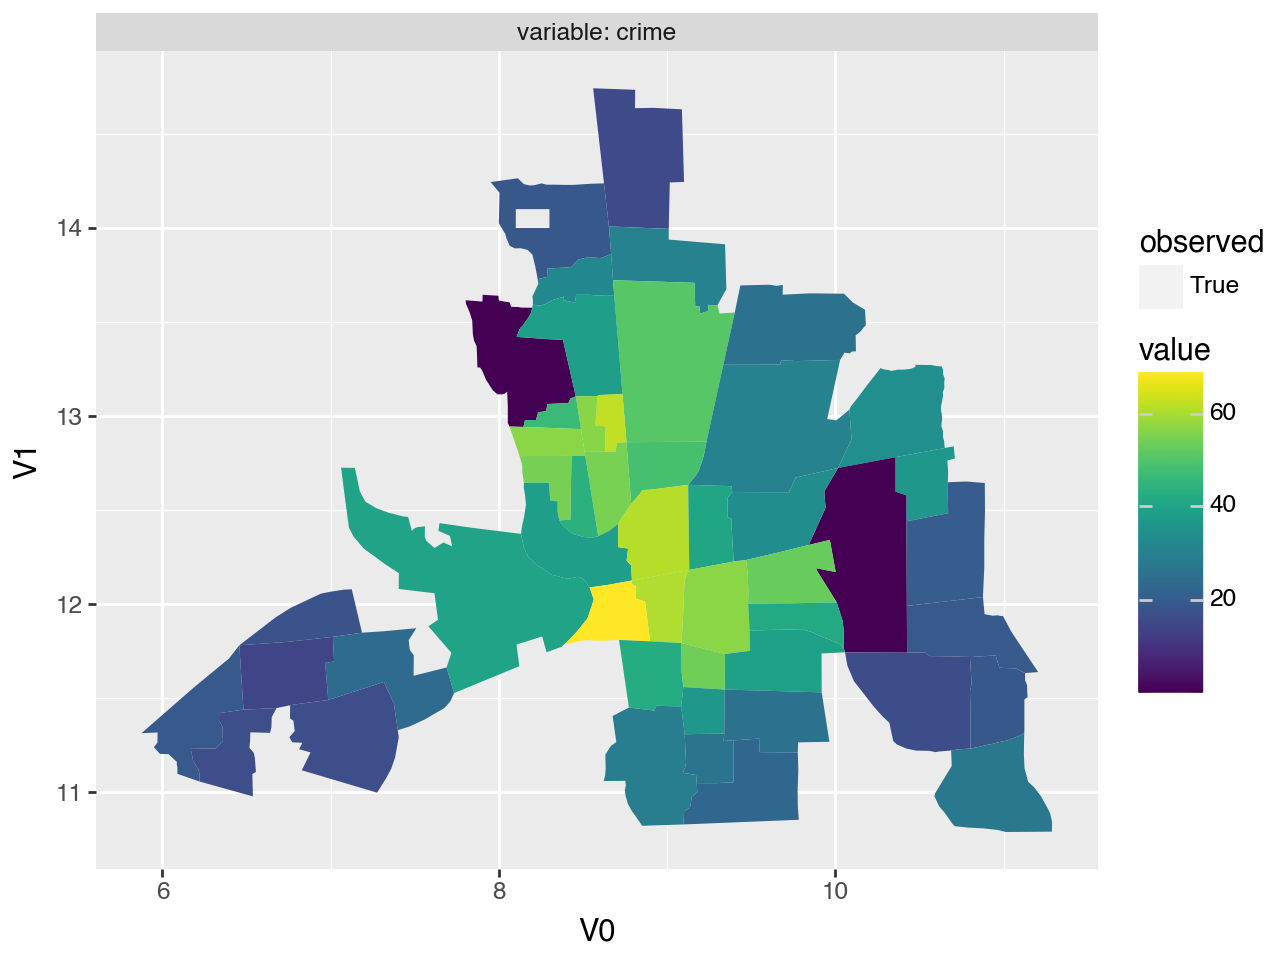

In [3]:
gam.plot_polys(region="district", which=["crime"], df=columb, polys=polys)

In [4]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y,label,observed
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076,0,True
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624,1,True
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719,2,True
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962,3,True
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366,4,True


## Model Definition

### Setup response model

In [5]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [6]:
loc += tb.lin("area")

# I use scale=1.0 for demo; otherwise there's no nonlinearity
smooth = tb.ps("income", scale=1.0, k=20)
loc += tb.vc("area", by=smooth)

liesel.model.model - INFO - Unnamed variables and/or nodes were temporarily named.


### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


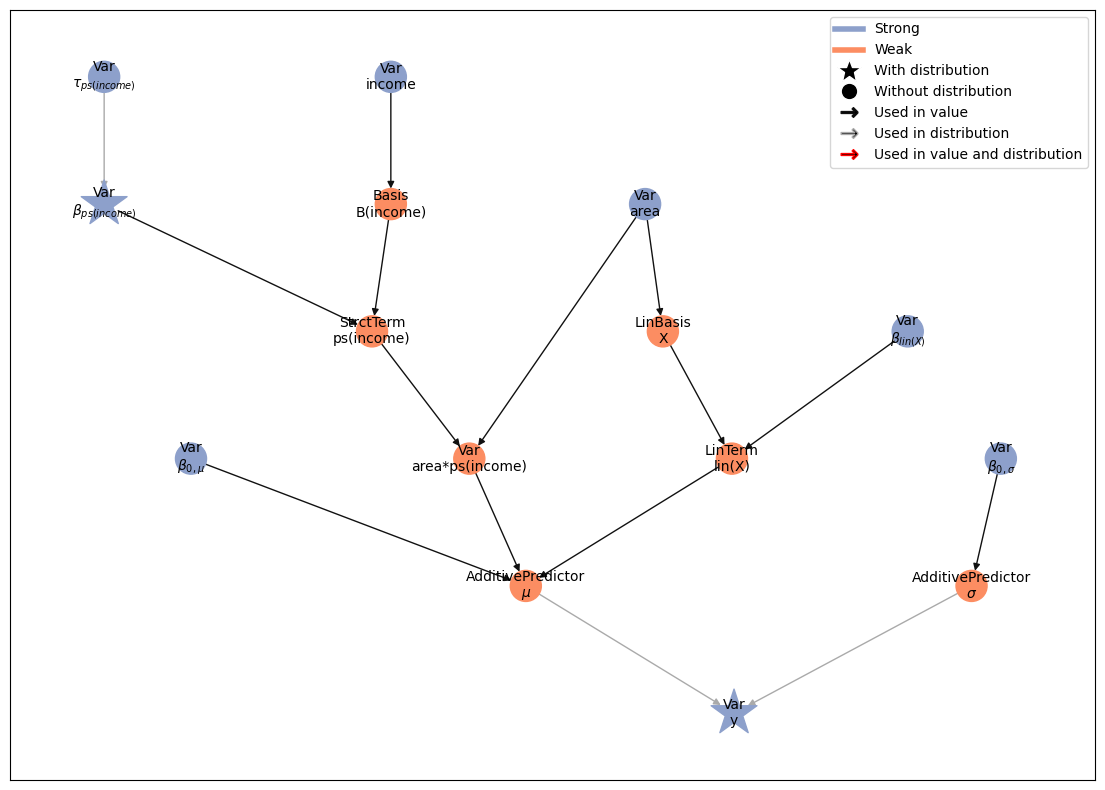

In [7]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [8]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_burnin(3000)
eb.add_posterior(10_000, thinning=10)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{ps(income)}$', '$\\beta_{lin(X)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: BURNIN, 3000 transitions, 1000 jitted together
100%|██████████████████████████████████████████| 3/3 [00:03<00:00,  1.05s/chunk]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Finished warmup
liesel.goose.engine - INFO - Starting epoch: POSTERIOR, 10000 transitions, 1000 jitted together
100%|████████████████████████████████████████| 10/10 [00:00<00:00, 10.34chunk/s]
liesel.goose.engine - INFO - Finished epoch


### MCMC summary

In [9]:
summary = gs.Summary(results)
summary

Parameter summary:

                               kernel       mean         sd     q_0.05  \
parameter            index                                               
$\beta_{0,\mu}$      ()     kernel_01  43.391140   3.366579  37.937537   
$\beta_{0,\sigma}$   ()     kernel_00   2.578274   0.107992   2.404410   
$\beta_{lin(X)}$     (0,)   kernel_03 -35.269196  15.168326 -60.310472   
$\beta_{ps(income)}$ (0,)   kernel_02   0.021969   1.004871  -1.596882   
                     (1,)   kernel_02  -0.036039   1.001104  -1.660604   
                     (2,)   kernel_02   0.014698   1.013416  -1.673915   
                     (3,)   kernel_02   0.028991   1.004531  -1.623405   
                     (4,)   kernel_02  -0.001196   0.965355  -1.570153   
                     (5,)   kernel_02  -0.025677   1.008663  -1.701040   
                     (6,)   kernel_02  -0.024267   1.008338  -1.668561   
                     (7,)   kernel_02  -0.009935   0.992258  -1.650928   
                     (8,)   kernel_02   0.041307   0.965528  -1.542792   
                     (9,)   kernel_02  -0.021953   0.980754  -1.597951   
                     (10,)  kernel_02   0.004618   0.997596  -1.602746   
                     (11,)  kernel_02  -0.006033   0.978728  -1.610733   
                     (12,)  kernel_02   0.049197   0.995806  -1.603548   
                     (13,)  kernel_02  -0.090835   0.992792  -1.722934   
                     (14,)  kernel_02   0.154257   0.978700  -1.458221   
                     (15,)  kernel_02  -0.218342   0.956908  -1.826052   
                     (16,)  kernel_02   0.694740   0.926384  -0.831754   
                     (17,)  kernel_02   0.668956   0.640261  -0.388318   
                     (18,)  kernel_02 -10.438582   2.636226 -14.879080   

                                q_0.5     q_0.95  sample_size     ess_bulk  \
parameter            index                                                   
$\beta_{0,\mu}$      ()     43.370134  48.945009         4000  2411.448336   
$\beta_{0,\sigma}$   ()      2.575065   2.767230         4000  3721.120953   
$\beta_{lin(X)}$     (0,)  -35.178322 -10.583267         4000  2241.893591   
$\beta_{ps(income)}$ (0,)    0.028648   1.737700         4000  3908.197582   
                     (1,)   -0.039733   1.576322         4000  3574.884123   
                     (2,)    0.014581   1.694197         4000  3779.472613   
                     (3,)    0.025629   1.702308         4000  4000.345735   
                     (4,)   -0.006431   1.624117         4000  3796.446290   
                     (5,)   -0.035333   1.621115         4000  4002.483911   
                     (6,)   -0.006960   1.638577         4000  3876.955717   
                     (7,)   -0.000927   1.606830         4000  3927.522120   
                     (8,)    0.044304   1.633256         4000  3891.836037   
                     (9,)   -0.020468   1.609202         4000  3897.169620   
                     (10,)   0.001373   1.640568         4000  3690.435128   
                     (11,)  -0.015630   1.597220         4000  3784.525304   
                     (12,)   0.048111   1.685111         4000  3878.068795   
                     (13,)  -0.076297   1.522597         4000  3710.183565   
                     (14,)   0.136620   1.769688         4000  3716.395131   
                     (15,)  -0.217859   1.342845         4000  3498.112953   
                     (16,)   0.712509   2.191217         4000  3868.663743   
                     (17,)   0.675546   1.710092         4000  3856.886357   
                     (18,) -10.376647  -6.037162         4000  3606.876497   

                               ess_tail      rhat  
parameter            index                         
$\beta_{0,\mu}$      ()     3362.116664  1.000702  
$\beta_{0,\sigma}$   ()     3719.728872  0.999620  
$\beta_{lin(X)}$     (0,)   3284.642761  1.001789  
$\beta_{ps(income)}$ (0,)   4053.404557  0.999797  
                  

## Plots

In [10]:
samples = results.get_posterior_samples()

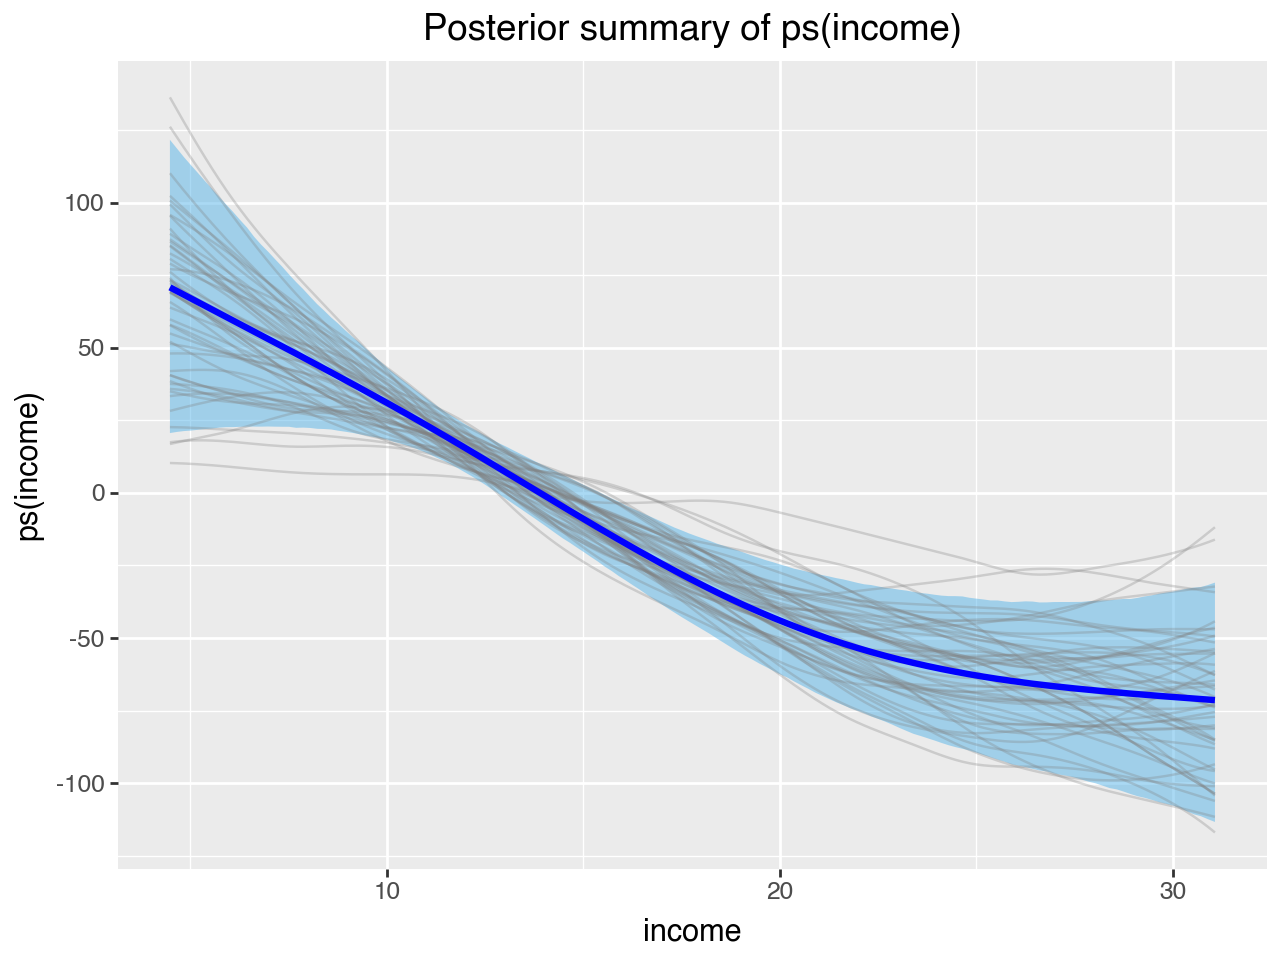

In [11]:
gam.plot_1d_smooth(term=model.vars["ps(income)"], samples=samples)